# Bayesian Independent Component Analysis

In this notebook, we'll use Coin SVGD to perform Bayesian independent component analysis.

As usual, let's start by importing the packages we'll need.

In [1]:
import os
import time
import jax.numpy as jnp
from sgmcmcjax import ksd

from plot_utils import *
from utils import * 
from main import CoinSVGD

Let's also setup some directories for saving results, plots, etc.

In [72]:
plot_dir = "plots/SVGD/BayesianICA"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

results_dir = "results/SVGD/BayesICA"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

Now we can define our model.

In [55]:
class BayesianICA:
    """
    Bayesian independent component analysis (ICA) model
    We follow the setup in Korba et al. 2021: see https://github.com/pierreablin/ksddescent/.
    """

    def __init__(self, n, p, sigma, seed=1):
        self.n = n
        self.p = p
        self.sigma = sigma

        self.W = sigma * np.random.randn(self.p, self.p)
        self.A = np.linalg.pinv(self.W)
        self.S = np.random.laplace(size=(self.p, self.n))
        self.X = np.dot(self.A, self.S)

        np.random.seed(seed)

    @staticmethod
    def amari_distance(W, A):
        """
        Compute the Amari distance between matrices W and A.

        Inputs
        W : ndarray, shape (n_features, n_features)
            Input matrix
        A : ndarray, shape (n_features, n_features)
            Input matrix

        Outputs:
        d : float
            The Amari distance
        """
        P = np.dot(W, A)

        def s(r):
            return np.sum(np.sum(r ** 2, axis=1) / np.max(r ** 2, axis=1) - 1)

        return (s(np.abs(P)) + s(np.abs(P.T))) / (2 * P.shape[0])

    def ln_prob_grad(self, theta):
        """"
        Compute gradient of log-prob.
        
        Inputs
        theta : ndarray, shape (N, p**2)
                set of particles 
        
        Outputs:
        ln_prob_grad : ndarray, shape (N, p**2)
                gradient of log-prob of particles
         
        """
        N, _ = theta.shape
        theta_list = theta.reshape(N, self.p, self.p)
        z = np.matmul(theta_list,self.X)
        psi = np.matmul(np.tanh(z), np.transpose(self.X)) / self.n - np.transpose(np.linalg.inv(theta_list),(0,2,1))
        sc = - psi - theta_list / self.sigma
        return sc.reshape(N, self.p ** 2)

Let's run some experiments.

### Experiment 1: Coin SVGD vs SVGD

First we'll just use Coin SVGD and SVGD to generate samples from the posterior, and see how they compare.

* For now, we'll look at two different dimensions for the model: p = 2, p = 4.
* We'll tune the SVGD learning rate with p = 2, and use this for all of the experiments.

In [69]:
# model parameters
n = 1000
sigma = 1
p_vals = [2,4,8,16]

# algorithm parameters
n_par = 10
n_iter = 1000

# tuning grid parameters
steps = np.logspace(-5, 0, 6)
n_steps = len(steps)
amari_dists = list() 
n_reps = 10
best_lr = np.zeros(len(p_vals))

for kk, p in enumerate(p_vals):
    
    # print progress
    print("Tuning learning rate for p = " + str(p))
    
    for ii, step in enumerate(steps):

        print("Step: " + str(ii+1) + "/" + str(n_steps))
        amari_dist_tmp = list()

        for jj in range(n_reps):

            np.random.seed(jj)

            # model
            ICA = BayesianICA(n=n, p=p, sigma=sigma)

            # initialisation
            theta0 = np.random.normal(0, 1, (n_par, p ** 2))

            # SVGD
            theta = CoinSVGD().svgd_update(theta0.copy(), ICA.ln_prob_grad, n_iter, step)[-1]

            # reshape output
            w = theta.reshape(n_par, p, p)

            # compute amari distance
            amari_dist = np.sort([ICA.amari_distance(w_, ICA.A) for w_ in w])

            # update
            amari_dist_tmp.append(np.sum(amari_dist))

        amari_dists.append(amari_dist_tmp)

    amari_dists_sum = [sum(x) for x in amari_dists]
    best_lr[kk] = steps[np.argmin(amari_dists_sum)]
        
    print("The best learning rate is " + str(best_lr[kk]))

Tuning learning rate for p = 2
Step: 1/6
Step: 2/6
Step: 3/6
Step: 4/6
Step: 5/6
Step: 6/6
The best learning rate is 0.1
Tuning learning rate for p = 4
Step: 1/6
Step: 2/6
Step: 3/6
Step: 4/6
Step: 5/6
Step: 6/6
The best learning rate is 0.1
Tuning learning rate for p = 8
Step: 1/6
Step: 2/6
Step: 3/6
Step: 4/6
Step: 5/6
Step: 6/6
The best learning rate is 0.1
Tuning learning rate for p = 16
Step: 1/6
Step: 2/6
Step: 3/6
Step: 4/6
Step: 5/6
Step: 6/6
The best learning rate is 0.1


Running Coin SVGD and SVGD with p = 2
Rep: 1/50
Rep: 6/50
Rep: 11/50
Rep: 16/50
Rep: 21/50
Rep: 26/50
Rep: 31/50
Rep: 36/50
Rep: 41/50
Rep: 46/50


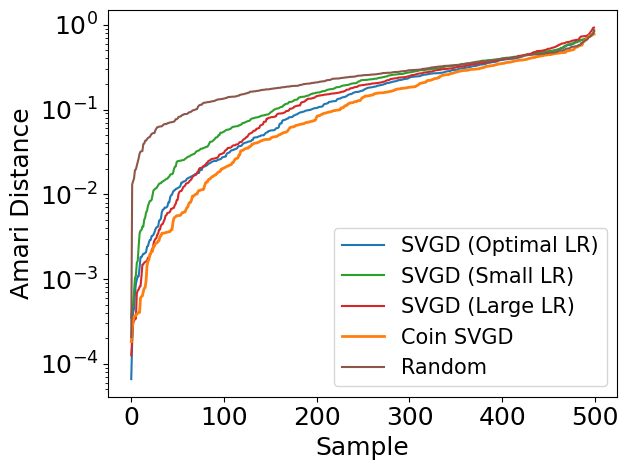

Running Coin SVGD and SVGD with p = 4
Rep: 1/50
Rep: 6/50
Rep: 11/50
Rep: 16/50
Rep: 21/50
Rep: 26/50
Rep: 31/50
Rep: 36/50
Rep: 41/50
Rep: 46/50


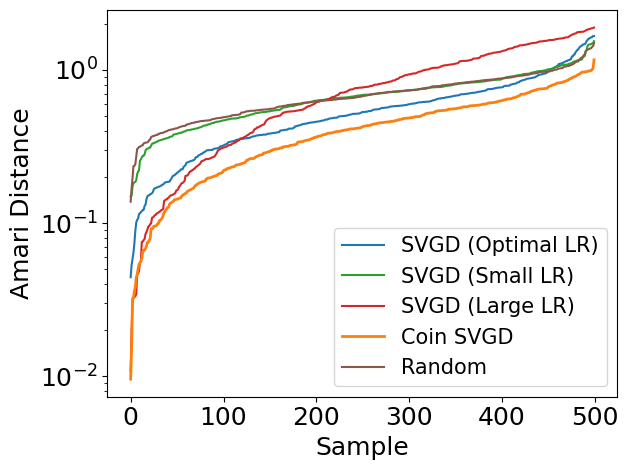

Running Coin SVGD and SVGD with p = 8
Rep: 1/50
Rep: 6/50
Rep: 11/50
Rep: 16/50
Rep: 21/50
Rep: 26/50
Rep: 31/50
Rep: 36/50
Rep: 41/50
Rep: 46/50


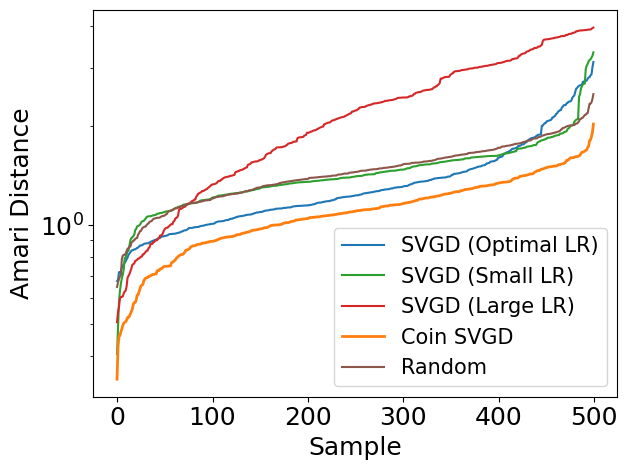

Running Coin SVGD and SVGD with p = 16
Rep: 1/50
Rep: 6/50
Rep: 11/50
Rep: 16/50
Rep: 21/50
Rep: 26/50
Rep: 31/50
Rep: 36/50
Rep: 41/50
Rep: 46/50


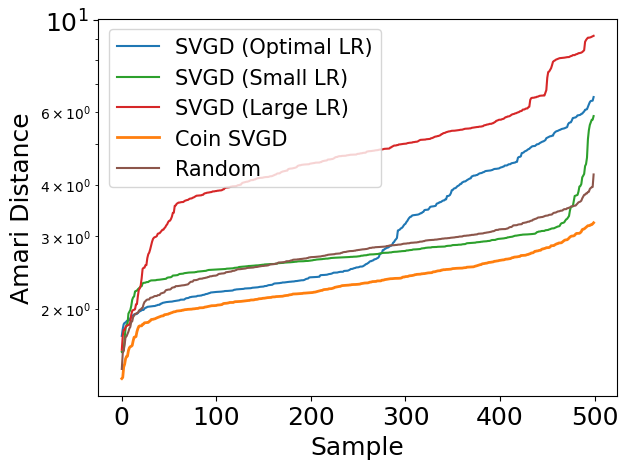

In [68]:
# experiment parameters
n_reps = 50
p_vals = [2, 4, 8, 16]

# algorithm parameters
n_par = 10
n_iter = 1000

for kk, p in enumerate(p_vals):

    print("Running Coin SVGD and SVGD with p = " + str(p) + "")
    
    good_lr = best_lr[kk]
    small_lr = 1e-1 * good_lr
    big_lr = 1e1 * good_lr
    
    amari_dists_svgd = np.zeros((n_reps, n_par))
    amari_dists_svgd_small = np.zeros((n_reps, n_par))
    amari_dists_svgd_big = np.zeros((n_reps, n_par))
    amari_dists_coin_svgd = np.zeros((n_reps, n_par))
    amari_dists_random = np.zeros((n_reps, n_par))

    for ii in range(n_reps):

        if ii % 5 == 0:
            print("Rep: " + str(ii+1) + "/" + str(n_reps))
        
        np.random.seed(ii+10)
        
        # model
        ICA = BayesianICA(n=n,p=p,sigma=sigma)

        # initialisation
        theta0 = np.random.normal(0, 1, (n_par, p ** 2))

        # SVGD
        theta_svgd = CoinSVGD().svgd_update(theta0.copy(), ICA.ln_prob_grad,n_iter, good_lr)[-1]
        theta_svgd_small = CoinSVGD().svgd_update(theta0.copy(), ICA.ln_prob_grad, n_iter, small_lr)[-1]
        theta_svgd_big = CoinSVGD().svgd_update(theta0.copy(), ICA.ln_prob_grad, n_iter, big_lr)[-1]

        # coin SVGD
        theta_coin_svgd = CoinSVGD().coin_update(theta0.copy(), ICA.ln_prob_grad, n_iter)[-1]

        # reshape output
        w_fin_svgd = theta_svgd.reshape(n_par, p, p)
        w_fin_svgd_small = theta_svgd_small.reshape(n_par, p, p)
        w_fin_svgd_big = theta_svgd_big.reshape(n_par,p,p)
        w_fin_coin_svgd = theta_coin_svgd.reshape(n_par, p, p)

        # compute amari distance
        amari_dist_svgd = np.sort([ICA.amari_distance(w, ICA.A) for w in w_fin_svgd])
        amari_dist_svgd_small = np.sort([ICA.amari_distance(w, ICA.A) for w in w_fin_svgd_small])
        amari_dist_svgd_big = np.sort([ICA.amari_distance(w, ICA.A) for w in w_fin_svgd_big])
        amari_dist_coin = np.sort([ICA.amari_distance(w, ICA.A) for w in w_fin_coin_svgd])
        amari_rand_dist = np.sort([ICA.amari_distance(np.random.randn(p, p), ICA.A) for w in w_fin_svgd])

        # update
        amari_dists_svgd[ii,:] = amari_dist_svgd
        amari_dists_svgd_small[ii,:] = amari_dist_svgd_small
        amari_dists_svgd_big[ii,:] = amari_dist_svgd_big
        amari_dists_coin_svgd[ii,:] = amari_dist_coin
        amari_dists_random[ii,:] = amari_rand_dist

    # save
    np.save(samples_results_dir + "/" + str(p) + "_svgd", amari_dists_svgd)
    np.save(samples_results_dir + "/" + str(p) + "_svgd_small", amari_dists_svgd_small)
    np.save(samples_results_dir + "/" + str(p) + "_svgd_big", amari_dists_svgd_big)
    np.save(samples_results_dir + "/" + str(p) + "_coin_svgd", amari_dists_coin_svgd)
    np.save(samples_results_dir + "/" + str(p) + "_random", amari_dists_random)
    
    plt.plot(np.sort(amari_dists_svgd.flatten()), label="SVGD (Optimal LR)", color="C0")
    plt.plot(np.sort(amari_dists_svgd_small.flatten()), label="SVGD (Small LR)", color="C2")
    plt.plot(np.sort(amari_dists_svgd_big.flatten()), label="SVGD (Large LR)", color="C3")
    plt.plot(np.sort(amari_dists_coin_svgd.flatten()), label="Coin SVGD", color="C1")
    plt.plot(np.sort(amari_dists_random.flatten()), label="Random", color="C5")
    plt.legend(prop={'size': 20})
    plt.yscale("log")
    plt.ylabel("Amari Distance", fontsize=20)
    plt.xlabel("Sample", fontsize=20)
    plt.legend(prop={'size': 20})
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
    fname = samples_plot_dir + "/" + "amari_plot_n_" + str(n) + "_p_" + str(p) + ".pdf"
    plt.tight_layout()
    plt.savefig(fname, format="pdf")
    plt.show()